In [1]:
import sys
import os
project_dir = os.path.abspath("/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/scripts")
#---------- Define paths for the specific subfolders
data_scripts_path = os.path.join(project_dir, "data_processing")
model_scripts_path = os.path.join(project_dir, "model")
#---------- Append the subfolder paths to sys.path
sys.path.append(data_scripts_path)
sys.path.append(model_scripts_path)

In [2]:
from packages import*

2025-04-08 12:13:19.000390: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 12:13:19.060384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 12:13:20.261320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from season_data_loader import x_input, y_input
from global_mean import  global_mean
from temporal_ednn import ednn_reg_model

## Load Data

In [4]:
#---------- Compute CLM PPE season
clm_ppe_path ="/bsuhome/ksilwimba/scratch/NCAR/Data/LAI/TLAI"
djf_seas_tr, mam_seas_tr, jja_seas_tr, son_seas_tr = y_input(clm_ppe_path, start_year=1901, end_year=2000)
djf_seas_va, mam_seas_va, jja_seas_va, son_seas_va = y_input(clm_ppe_path, start_year=2000, end_year=2014)

In [5]:
djf_seas_tr

<xarray.Dataset>
Dimensions:  (gridcell: 77, sample: 150000)
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 ... 500 500 500 500 500 500 500 500
  * time     (sample) object 1901-01-01 00:00:00 ... 2000-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables:
    TLAI     (gridcell, sample) float32 dask.array<chunksize=(77, 1500), meta=np.ndarray>

In [6]:
param_file_path = "/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/lhc220926.txt"

#---------- Create x-train input
x_dja_tr, x_dja_tr_no_cyclic = x_input(djf_seas_tr, param_file_path)
x_mam_tr, x_mam_tr_no_cyclic = x_input(mam_seas_tr, param_file_path)
x_jja_tr, x_jja_tr_no_cyclic = x_input(jja_seas_tr, param_file_path)
x_son_tr, x_son_tr_no_cyclic = x_input(son_seas_tr, param_file_path)

#---------- Create x-train input
x_dja_va, x_dja_va_no_cyclic = x_input(djf_seas_va, param_file_path)
x_mam_va, x_mam_va_no_cyclic = x_input(mam_seas_va, param_file_path)
x_jja_va, x_jja_va_no_cyclic = x_input(jja_seas_va, param_file_path)
x_son_va, x_son_va_no_cyclic = x_input(son_seas_va, param_file_path)

In [7]:
x_dja_tr.shape

(150000, 35)

## Compute Global Mean 

In [8]:
#----------- Area weight
land_area = xr.open_dataset('/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/sparsegrid_landarea.nc').landarea

#----------- Train Y global mean 
djf_tr_gmean = global_mean(djf_seas_tr, land_area).TLAI.values.reshape(-1,1)
mam_tr_gmean = global_mean(mam_seas_tr, land_area).TLAI.values.reshape(-1,1)
jja_tr_gmean = global_mean(jja_seas_tr, land_area).TLAI.values.reshape(-1,1)
son_tr_gmean = global_mean(son_seas_tr, land_area).TLAI.values.reshape(-1,1)

#----------- Validation Y global mean 
djf_va_gmean = global_mean(djf_seas_va, land_area).TLAI.values.reshape(-1,1)
mam_va_gmean = global_mean(mam_seas_va, land_area).TLAI.values.reshape(-1,1)
jja_va_gmean = global_mean(jja_seas_va, land_area).TLAI.values.reshape(-1,1)
son_va_gmean = global_mean(son_seas_va, land_area).TLAI.values.reshape(-1,1)

## Scale Data

In [9]:
#----------- Scaled Y train global mean 
scaler_djf = StandardScaler()
scaler_mam = StandardScaler()
scaler_jja = StandardScaler()
scaler_son = StandardScaler()
djf_tr_gmean_scaled = scaler_djf.fit_transform(djf_tr_gmean)
mam_tr_gmean_scaled = scaler_mam.fit_transform(mam_tr_gmean)
jja_tr_gmean_scaled = scaler_jja.fit_transform(jja_tr_gmean)
son_tr_gmean_scaled = scaler_son.fit_transform(son_tr_gmean)

#----------- Scaled Y validation global mean 
djf_va_gmean_scaled = scaler_djf.transform(djf_va_gmean)
mam_va_gmean_scaled = scaler_mam.transform(mam_va_gmean)
jja_va_gmean_scaled = scaler_jja.transform(jja_va_gmean)
son_va_gmean_scaled = scaler_son.transform(son_va_gmean)

In [10]:
#----------- Scaled x train and validation
scaler_djf_x = StandardScaler()
scaler_mam_x = StandardScaler()
scaler_jja_x = StandardScaler()
scaler_son_x = StandardScaler()
x_dja_tr_scaled = scaler_djf_x.fit_transform(x_dja_tr)
x_mam_tr_scaled = scaler_mam_x.fit_transform(x_mam_tr)
x_jja_tr_scaled = scaler_jja_x.fit_transform(x_jja_tr)
x_son_tr_scaled = scaler_son_x.fit_transform(x_son_tr)


x_dja_va_scaled = scaler_djf_x.transform(x_dja_va)
x_mam_va_scaled = scaler_mam_x.transform(x_mam_va)
x_jja_va_scaled = scaler_jja_x.transform(x_jja_va)
x_son_va_scaled = scaler_son_x.transform(x_son_va) 

In [11]:
# #----------- Scaled x train and validation no cyclical encoding
# scaler_x_no_cyclic = StandardScaler()
# x_dja_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_dja_tr_no_cyclic)
# x_mam_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_mam_tr_no_cyclic)
# x_jja_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_jja_tr_no_cyclic)
# x_son_tr_scaled_ = scaler_x_no_cyclic.fit_transform(x_son_tr_no_cyclic)

# x_dja_va_scaled_ = scaler_x_no_cyclic.transform(x_dja_va_no_cyclic)
# x_mam_va_scaled_ = scaler_x_no_cyclic.transform(x_mam_va_no_cyclic)
# x_jja_va_scaled_ = scaler_x_no_cyclic.transform(x_jja_va_no_cyclic)
# x_son_va_scaled_ = scaler_x_no_cyclic.transform(x_son_va_no_cyclic) 

## EDNN Model 

## Train EDNN Model 

In [12]:
#---------- Train  DJF season
loss_weight = 0.4#0.5
n_layers = 4#6
n_epoch = 18
batch_size=500

model_folder = "/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/saved_model"

#---------- Train  DJF season
model_path = model_folder+"/djf_ednn_reg_model.keras"
p_with_unc_djf, p_without_unc_djf, model_djf, history_djf = ednn_reg_model(
    x_dja_tr_scaled,
    djf_tr_gmean,
    batch_size,
    model_path,
    hidden_layers=n_layers,
    epochs=n_epoch,
    loss_weight=loss_weight
)

#---------- Train  MAM season
model_path = model_folder+"/mam_ednn_reg_model.keras"
p_with_unc_mam, p_without_unc_mam, model_mam, history_mam = ednn_reg_model(
    x_mam_tr_scaled,
    mam_tr_gmean,
    batch_size,
    model_path,
    hidden_layers=n_layers,
    epochs=n_epoch,
    loss_weight=loss_weight
)

#---------- Train JJA season
model_path = model_folder+"/jja_ednn_reg_model.keras"
p_with_unc_jja, p_without_unc_jja, model_jja, history_jja = ednn_reg_model(
    x_jja_tr_scaled,
    jja_tr_gmean,
    batch_size,
    model_path,
    hidden_layers=n_layers,
    epochs=n_epoch,
    loss_weight=loss_weight
)

#---------- Train SON season
model_path = model_folder+"/son_ednn_reg_model.keras"
p_with_unc_son, p_without_unc_son, model_son, history_son = ednn_reg_model(
    x_son_tr_scaled,
    son_tr_gmean,
    batch_size,
    model_path,
    hidden_layers=n_layers,
    epochs=n_epoch,
    loss_weight=loss_weight
)


Epoch 1/18
300/300 - 2s - 6ms/step - loss: -1.5180e+00 - mse: 2.0482
Epoch 2/18
300/300 - 0s - 1ms/step - loss: -2.4043e+00 - mse: 2.2170
Epoch 3/18
300/300 - 0s - 1ms/step - loss: -2.5330e+00 - mse: 2.0858
Epoch 4/18
300/300 - 0s - 1ms/step - loss: -2.5988e+00 - mse: 2.0865
Epoch 5/18
300/300 - 0s - 2ms/step - loss: -2.6548e+00 - mse: 2.1291
Epoch 6/18
300/300 - 0s - 2ms/step - loss: -2.6768e+00 - mse: 2.2365
Epoch 7/18
300/300 - 0s - 1ms/step - loss: -2.7320e+00 - mse: 2.3656
Epoch 8/18
300/300 - 1s - 2ms/step - loss: -2.7611e+00 - mse: 2.4554
Epoch 9/18
300/300 - 1s - 2ms/step - loss: -2.7837e+00 - mse: 2.5412
Epoch 10/18
300/300 - 1s - 2ms/step - loss: -2.8021e+00 - mse: 2.6013
Epoch 11/18
300/300 - 0s - 2ms/step - loss: -2.8116e+00 - mse: 2.6023
Epoch 12/18
300/300 - 0s - 2ms/step - loss: -2.8367e+00 - mse: 2.6497
Epoch 13/18
300/300 - 1s - 2ms/step - loss: -2.8445e+00 - mse: 2.6791
Epoch 14/18
300/300 - 1s - 2ms/step - loss: -2.8465e+00 - mse: 2.7179
Epoch 15/18
300/300 - 0s - 2m

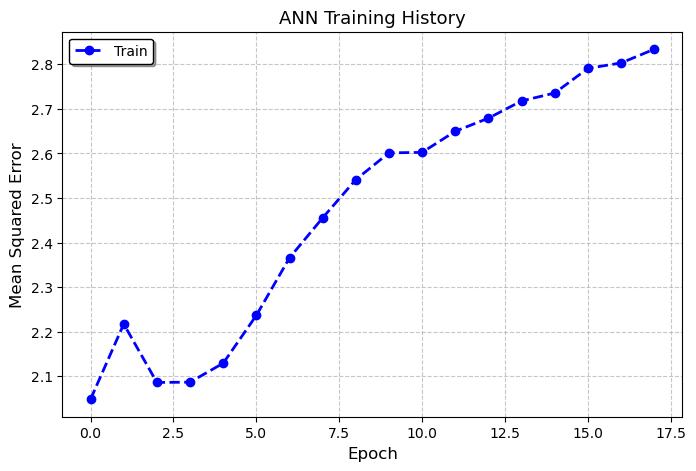

In [13]:
plt.figure(figsize=(8, 5))
# plt.plot(history_djf.epoch, history_djf.history['val_mse'], label='Validation', marker='o', linestyle='-', linewidth=2, color='red')
plt.plot(history_djf.epoch, history_djf.history['mse'], label='Train', marker='o', linestyle='--', linewidth=2, color='blue')
plt.legend(shadow = True, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Mean Squared Error', fontsize = 12)
plt.xlabel('Epoch', fontsize=12)
plt.title('ANN Training History', fontsize=13)
plt.savefig("./Figures/TSgrid_mse_anom.pdf", bbox_inches='tight')
plt.show()

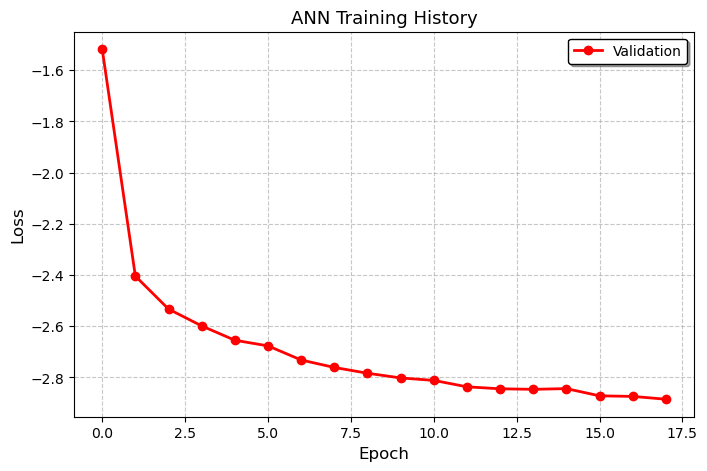

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(history_djf.epoch, history_djf.history['loss'], label='Validation', marker='o', linestyle='-', linewidth=2, color='red')
# plt.plot(history_djf.epoch, history_djf.history['mse'], label='Train', marker='o', linestyle='--', linewidth=2, color='blue')
plt.legend(shadow = True, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize=12)
plt.title('ANN Training History', fontsize=13)
plt.savefig("./Figures/TSgrid_mse_anom.pdf", bbox_inches='tight')
plt.show()

In [15]:
# =============================================================================
# cyclical encoded prediction 
# =============================================================================

#------------- djf predictions
djf_pred_ = model_djf.predict(x_dja_va_scaled, return_uncertainties=True)
# djf_pred = scaler_y.inverse_transform(djf_pred_[:, 0].reshape(-1, 1))

#------------- mam prediction
mam_pred_ = model_mam.predict(x_mam_va_scaled, return_uncertainties=True)
# mam_pred = scaler_y.inverse_transform(mam_pred_[:, 0].reshape(-1, 1))

#------------- jja prediction
jja_pred_ = model_jja.predict(x_jja_va_scaled, return_uncertainties=True)
# jja_pred = scaler_y.inverse_transform(jja_pred_[:, 0].reshape(-1, 1))

#------------- son prediction
son_pred_ = model_son.predict(x_son_va_scaled, return_uncertainties=True)
# son_pred = scaler_y.inverse_transform(son_pred_[:, 0].reshape(-1, 1))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [16]:
model_djf.predict(x_dja_va_scaled,return_uncertainties=True).shape

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


(22500, 3)

In [17]:
djf_va_gmean_scaled

array([[ 0.90068922],
       [ 0.60484428],
       [ 0.95294781],
       ...,
       [ 0.04753393],
       [-0.22274602],
       [ 0.34094399]])

In [18]:
# =============================================================================
# PPE Data Frame
# =============================================================================

# ---------- DJF Season DataFrame Construction
djf_ppe_pred = pd.DataFrame({
    "member": djf_seas_va.member,
    "time": djf_seas_va.time,
    "djf_ednn_mu": djf_pred_[:, 0].squeeze(),
    "djf_clm_model": djf_va_gmean.squeeze(),
    "djf_ednn_alea": djf_pred_[:, 1].squeeze(),
    "djf_ednn_epis": djf_pred_[:, 2].squeeze()
})

# ---------- MAM Season DataFrame Construction
mam_ppe_pred = pd.DataFrame({
    "member": mam_seas_va.member,
    "time": mam_seas_va.time,
    "mam_ednn_mu": mam_pred_[:, 0].squeeze(),
    "mam_clm_model": mam_va_gmean.squeeze(),
    "mam_ednn_alea": mam_pred_[:, 1].squeeze(),
    "mam_ednn_epis": mam_pred_[:, 2].squeeze()
})

# ---------- JJA Season DataFrame Construction
jja_ppe_pred = pd.DataFrame({
    "member": jja_seas_va.member,
    "time": jja_seas_va.time,
    "jja_ednn_mu": jja_pred_[:, 0].squeeze(),
    "jja_clm_model": jja_va_gmean.squeeze(),
    "jja_ednn_alea": jja_pred_[:, 1].squeeze(),
    "jja_ednn_epis": jja_pred_[:, 2].squeeze()
})

# ---------- SON Season DataFrame Construction
son_ppe_pred = pd.DataFrame({
    "member": son_seas_va.member,
    "time": son_seas_va.time,
    "son_ednn_mu": son_pred_[:, 0].squeeze(),
    "son_clm_model": son_va_gmean.squeeze(),
    "son_ednn_alea": son_pred_[:, 1].squeeze(),
    "son_ednn_epis": djf_pred_[:, 2].squeeze()  # Verify if using djf_pred_ is intended for SON
})


In [19]:
mam_ppe_pred

,member,time,mam_ednn_mu,mam_clm_model,mam_ednn_alea,mam_ednn_epis
0,1,2000-03-01 00:00:00,0.462451,0.481438,0.000018,0.000127
1,1,2000-04-01 00:00:00,0.458885,0.477524,0.000018,0.000128
2,1,2000-05-01 00:00:00,0.461025,0.482535,0.000019,0.000134
3,1,2001-03-01 00:00:00,0.463745,0.463922,0.000017,0.000126
4,1,2001-04-01 00:00:00,0.460179,0.460701,0.000018,0.000128
...,...,...,...,...,...,...
22495,500,2013-04-01 00:00:00,0.370434,0.357486,0.000045,0.000215
22496,500,2013-05-01 00:00:00,0.372523,0.349088,0.000047,0.000226
22497,500,2014-03-01 00:00:00,0.374524,0.356373,0.000044,0.000216
22498,500,2014-04-01 00:00:00,0.371594,0.350568,0.000045,0.000215


In [20]:
def convert_cftime_to_datetime64(cf_time):
    """
    Convert a cftime object to numpy.datetime64 format.
    
    Parameters:
        cf_time: A cftime object with attributes year, month, and day.
        
    Returns:
        np.datetime64: The corresponding datetime64 object.
    """
    return np.datetime64(f"{cf_time.year}-{cf_time.month:02d}-{cf_time.day:02d}")

# ---------- Convert 'time' column for DJF DataFrame and extract month
djf_ppe_pred['time'] = djf_ppe_pred['time'].apply(convert_cftime_to_datetime64)
djf_ppe_pred["month"] = djf_ppe_pred.time.dt.month

# ---------- Convert 'time' column for MAM DataFrame and extract month
mam_ppe_pred['time'] = mam_ppe_pred['time'].apply(convert_cftime_to_datetime64)
mam_ppe_pred["month"] = mam_ppe_pred.time.dt.month

# ---------- Convert 'time' column for JJA DataFrame and extract month
jja_ppe_pred['time'] = jja_ppe_pred['time'].apply(convert_cftime_to_datetime64)
jja_ppe_pred["month"] = jja_ppe_pred.time.dt.month

# ---------- Convert 'time' column for SON DataFrame and extract month
son_ppe_pred['time'] = son_ppe_pred['time'].apply(convert_cftime_to_datetime64)
son_ppe_pred["month"] = son_ppe_pred.time.dt.month


In [21]:
df_djf = djf_ppe_pred[djf_ppe_pred['member'].isin(range(1, 500))]
df_mam = mam_ppe_pred[mam_ppe_pred['member'].isin(range(1, 500))]
df_jja = jja_ppe_pred[jja_ppe_pred['member'].isin(range(1, 500))]
df_son = son_ppe_pred[son_ppe_pred['member'].isin(range(1, 500))]

In [22]:
#---------- EDNN Mean 
df_djf_mean = df_djf[["djf_ednn_mu","djf_clm_model","djf_ednn_alea","djf_ednn_epis"]].mean()
df_mam_mean = df_mam[["mam_ednn_mu","mam_clm_model","mam_ednn_alea","mam_ednn_epis"]].mean()
df_jja_mean = df_jja[["jja_ednn_mu","jja_clm_model","jja_ednn_alea","jja_ednn_epis"]].mean()
df_son_mean = df_son[["son_ednn_mu","son_clm_model","son_ednn_alea","son_ednn_epis"]].mean()

In [23]:
df_djf[["djf_ednn_mu","djf_clm_model","djf_ednn_alea","djf_ednn_epis"]]

,djf_ednn_mu,djf_clm_model,djf_ednn_alea,djf_ednn_epis
0,0.525012,0.547562,0.000018,0.000097
1,0.487737,0.500539,0.000023,0.000113
2,0.555603,0.555869,0.000016,0.000095
3,0.526815,0.516597,0.000018,0.000097
4,0.489453,0.455728,0.000023,0.000114
...,...,...,...,...
22450,0.354102,0.332400,0.000017,0.000096
22451,0.395921,0.373617,0.000018,0.000109
22452,0.384246,0.348142,0.000018,0.000103
22453,0.356460,0.316837,0.000018,0.000097


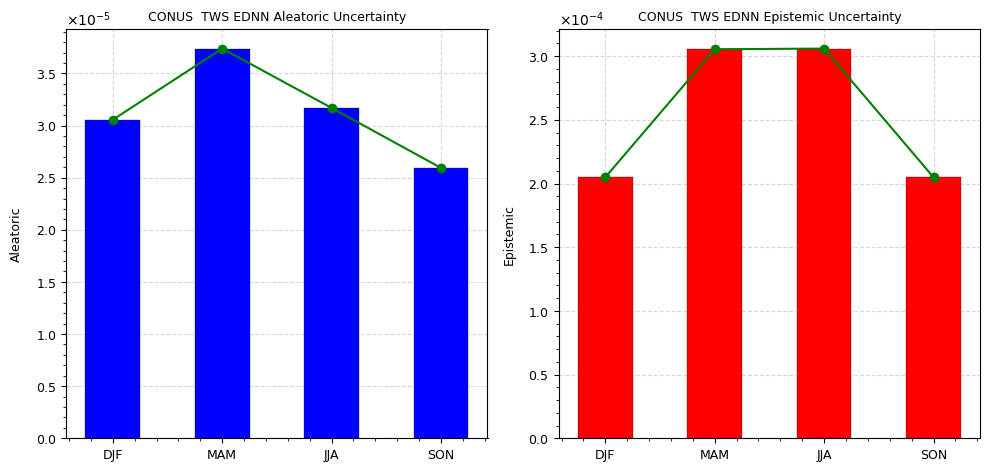

In [24]:
# =============================================================================
# Monthly Uncertainty Bar and Line Plotting
# =============================================================================

# ---------- Get the 'Dark2' colormap
cmap = cm.get_cmap('Dark2')

# ---------- Assign specific colors for aleatoric and epistemic uncertainties
colors_aleatoric = cmap.colors[:4]  # First 4 colors for Aleatoric
colors_epistemic = cmap.colors[4:]  # Remaining colors for Epistemic

# ---------- Construct data dictionary for uncertainties from the seasonal DataFrames
data = {
    "Aleatoric": pd.Series({
        "DJF": df_djf_mean["djf_ednn_alea"],
        "MAM": df_mam_mean["mam_ednn_alea"],
        "JJA": df_jja_mean["jja_ednn_alea"],
        "SON": df_son_mean["son_ednn_alea"]
    }),
    "Epistemic": pd.Series({
        "DJF": df_djf_mean["djf_ednn_epis"],
        "MAM": df_mam_mean["mam_ednn_epis"],
        "JJA": df_jja_mean["jja_ednn_epis"],
        "SON": df_son_mean["son_ednn_epis"]
    })
}

# ---------- Define titles and y-axis labels for the plots
titles = {
    "Aleatoric": "CONUS  TWS EDNN Aleatoric Uncertainty",
    "Epistemic": "CONUS  TWS EDNN Epistemic Uncertainty"
}
y_labels = {
    "Aleatoric": "Aleatoric",
    "Epistemic": "Epistemic"
}

# ---------- Create a figure with one row and two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# ---------- Define custom colors for each uncertainty type (publication-friendly)
custom_colors = {'epistemic': 'r', 'aleatoric': 'b'}

# ---------- Loop over each uncertainty type and plot the respective data
for ax, (key, data_series) in zip(axes, data.items()):
    # ---------- Select bar color based on the uncertainty type (using lower-case key)
    bar_color = custom_colors.get(key.lower(), '#4682b4')  # Default to steel blue
    # ---------- Create bar plot with enhanced styling
    bars = ax.bar(data_series.index, data_series.values, color=bar_color, 
                  width=0.5, edgecolor='black', linewidth=0.2, zorder=10)
    # ---------- Overlay a line plot using the same data
    ax.plot(data_series.index, data_series.values, color='g', 
            marker='o', linestyle='-', linewidth=1.5, zorder=20)
    # ---------- Set title and y-axis label
    ax.set_title(titles[key], fontsize=9)
    ax.set_ylabel(y_labels[key], fontsize=9, labelpad=9)
    # ---------- Customize grid and tick parameters
    ax.grid(True, linestyle='--', which='major', alpha=0.5)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.minorticks_on()
    # ---------- Set y-axis to scientific notation with appropriate formatting
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(formatter)
    # ---------- Ensure y-axis starts at 0 for bar plots
    ax.set_ylim(bottom=0)

# ---------- Final layout adjustments and save the figure as PDF
plt.tight_layout()
plt.savefig("./Figures/alea_epis.pdf", bbox_inches='tight')
plt.show()


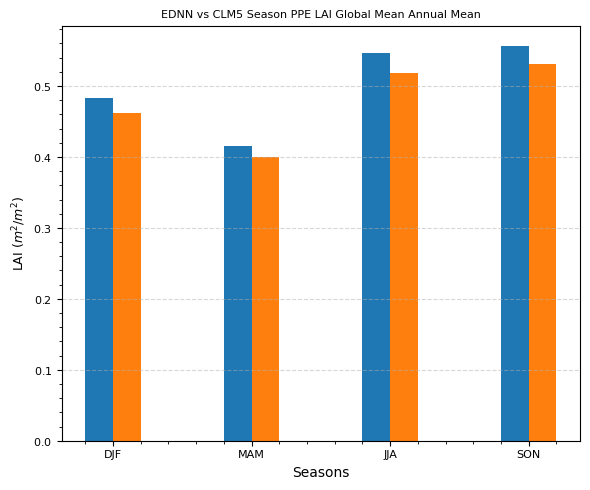

In [25]:
# =============================================================================
# Comparison of EDNN-PPE LAI versus CLM-PEE Model LAI
# =============================================================================

# ---------- Construct pandas Series for EDNN and CLM predictions across seasons
data_ednn = pd.Series({
    "DJF": df_djf_mean["djf_ednn_mu"],
    "MAM": df_mam_mean["mam_ednn_mu"],
    "JJA": df_jja_mean["jja_ednn_mu"],
    "SON": df_son_mean["son_ednn_mu"]
})

data_clm = pd.Series({
    "DJF": df_djf_mean["djf_clm_model"],
    "MAM": df_mam_mean["mam_clm_model"],
    "JJA": df_jja_mean["jja_clm_model"],
    "SON": df_son_mean["son_clm_model"]
})

# ---------- Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 5))

# ---------- Define the seasons and bar plotting parameters
seasons = data_ednn.index
bar_width = 0.4
indices = np.arange(len(seasons))

# ---------- Create bar plots for EDNN and CLM predictions
ax.bar(indices - bar_width/4, data_ednn.values, bar_width/2, label='EDNN-PPE LAI', color='#1f77b4')
ax.bar(indices + bar_width/4, data_clm.values, bar_width/2, label='CLM-PEE Model LAI', color='#ff7f0e')

# ---------- Add labels and title to the plot
ax.set_xlabel("Seasons", fontsize=10)
ax.set_ylabel("LAI ($m^2/m^2$)", fontsize=9)
ax.set_title("EDNN vs CLM5 Season PPE LAI Global Mean Annual Mean", fontsize=8)

# ---------- Set x-tick positions and labels
ax.set_xticks(indices)
ax.set_xticklabels(seasons, fontsize=8)

# ---------- Enable grid and format y-axis to use scientific notation
ax.grid(True, linestyle='--', alpha=0.5, axis='y')
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
ax.yaxis.set_major_formatter(formatter)

# ---------- Set tick parameters and enable minor ticks for clarity
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.minorticks_on()

# ---------- Adjust the layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/clm_edd_ppe.pdf", bbox_inches='tight')
plt.show()


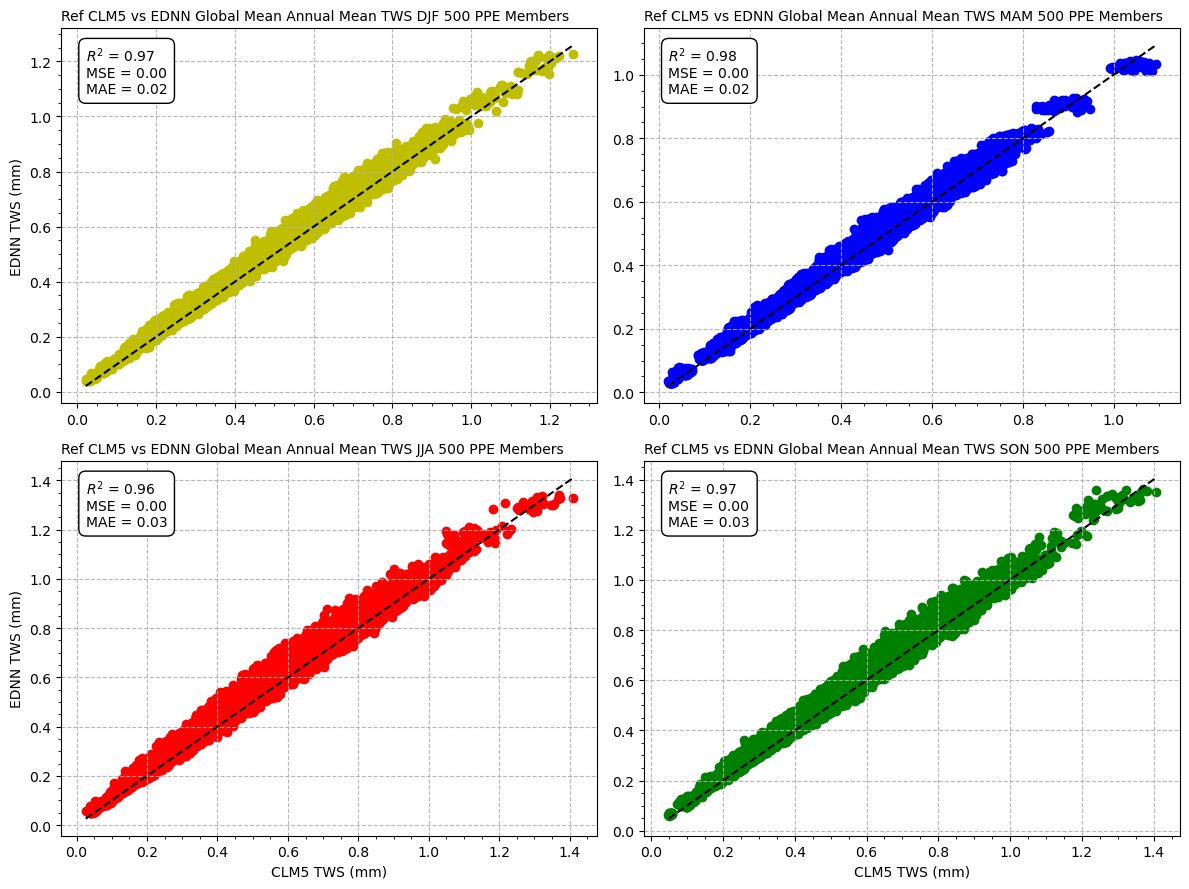

In [26]:
# =============================================================================
# Scatter Plots with Regression Metrics by Season
# =============================================================================

# ---------- Filter data by 'member' column: keep members in the range [1, 500)
df_djf = djf_ppe_pred[djf_ppe_pred['member'].isin(range(1, 500))]
df_mam = mam_ppe_pred[mam_ppe_pred['member'].isin(range(1, 500))]
df_jja = jja_ppe_pred[jja_ppe_pred['member'].isin(range(1, 500))]
df_son = son_ppe_pred[son_ppe_pred['member'].isin(range(1, 500))]

# ---------- Create a dictionary to hold data for each season
seasons = {
    "DJF": {"df": df_djf, "color": 'y', "model_col": "djf_clm_model", "ednn_col": "djf_ednn_mu"},
    "MAM": {"df": df_mam, "color": 'b', "model_col": "mam_clm_model", "ednn_col": "mam_ednn_mu"},
    "JJA": {"df": df_jja, "color": 'r', "model_col": "jja_clm_model", "ednn_col": "jja_ednn_mu"},
    "SON": {"df": df_son, "color": 'g', "model_col": "son_clm_model", "ednn_col": "son_ednn_mu"}
}

# ---------- Create a 2x2 grid of subplots for seasonal scatter plots
plt.figure(figsize=(12, 9))

# ---------- Loop over each season and create the scatter plot
for i, (season, info) in enumerate(seasons.items(), start=1):
    df = info["df"]
    
    # ---------- Calculate R², MSE, and MAE using scikit-learn metrics
    r2_value = r2_score(df[info["model_col"]], df[info["ednn_col"]])
    mse_value = mean_squared_error(df[info["model_col"]], df[info["ednn_col"]])
    mae_value = mean_absolute_error(df[info["model_col"]], df[info["ednn_col"]])
    
    # ---------- Get min and max values of the model column (for the 1:1 line)
    season_min = np.min(df[info["model_col"]])
    season_max = np.max(df[info["model_col"]])
    
    # ---------- Create subplot in a 2x2 grid
    plt.subplot(2, 2, i)
    plt.scatter(df[info["model_col"]], df[info["ednn_col"]], color=info["color"], label='')
    plt.plot([season_min, season_max], [season_min, season_max], linestyle='--', c='k', label='1:1 Line')
    
    # ---------- Conditionally set labels for the x- and y-axes
    if i > 2:  # Last row subplots
        plt.xlabel('CLM5 TWS (mm)', fontsize=10)
    if i % 2 == 1:  # First column subplots
        plt.ylabel('EDNN TWS (mm)', fontsize=10)
    
    # ---------- Set the title for each subplot (annotated with the season name)
    plt.title(f'Ref CLM5 vs EDNN Global Mean Annual Mean TWS {season} 500 PPE Members', fontsize=10, loc="left")
    
    # ---------- Add grid, minor ticks, and adjust tick parameters
    plt.grid(True, linestyle='--', alpha=0.9)
    plt.minorticks_on()
    plt.tick_params(axis='x', colors='black')
    plt.tick_params(axis='y', colors='black')
    
    # ---------- Annotate regression metrics in the upper left corner with a bounding box
    plt.text(season_min, season_max, f'$R^2$ = {r2_value:.2f}\nMSE = {mse_value:.2f}\nMAE = {mae_value:.2f}', 
             fontsize=10, color='black', verticalalignment='top',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# ---------- Adjust layout and save the figure
plt.tight_layout()
plt.savefig("./Figures/cyclic_seas_scatter_plot_with_metrics.pdf", bbox_inches='tight')
plt.show()


### Comparison of Uncertainty Distributions

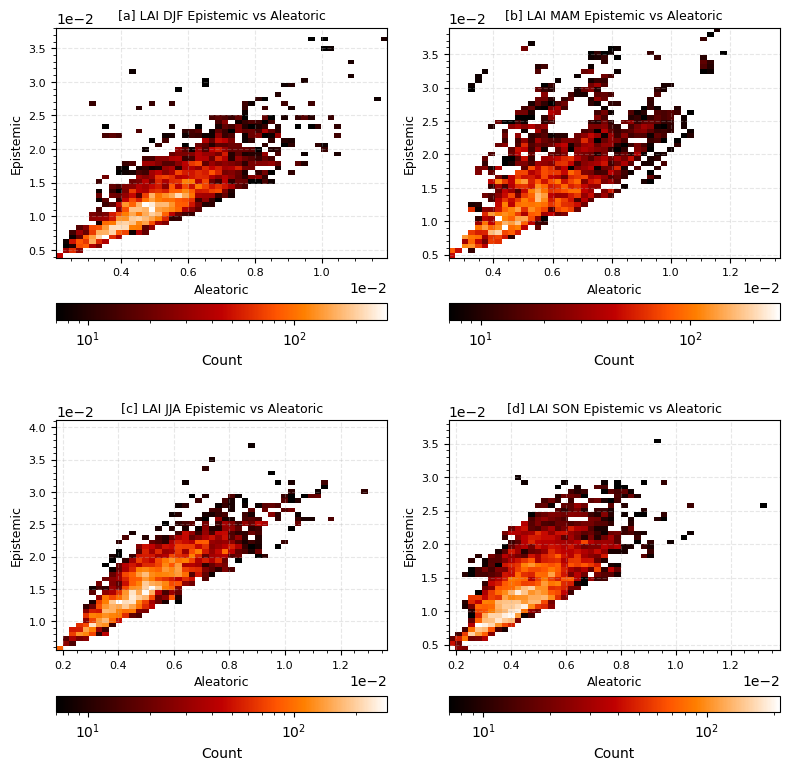

In [27]:
# =============================================================================
# 2D Histogram of LAI Uncertainty
# =============================================================================

# from matplotlib import cm
# ---------- Set global publication standards for PDF export
plt.rcParams['pdf.fonttype'] = 42  # Ensures fonts are embedded in PDF
plt.rcParams['ps.fonttype'] = 42

# ---------- Define a helper function to plot a 2D histogram with LogNorm
def plot_hist2d(ax, data_x, data_y, title):
    """
    Plots a 2D histogram with logarithmic color normalization on the given axes.
    
    Parameters:
      ax: matplotlib.axes.Axes
          The axis on which to plot.
      data_x: array-like
          Data for the x-axis (Aleatoric uncertainty).
      data_y: array-like
          Data for the y-axis (Epistemic uncertainty).
      title: str
          Title for the subplot.
    
    Returns:
      The output of ax.hist2d (tuple) for potential further customization.
    """
    # ---------- Compute the square roots of the input uncertainties
    x = np.sqrt(data_x)
    y = np.sqrt(data_y)
    
    # ---------- Plot 2D histogram with 50 bins and LogNorm for color scaling
    h = ax.hist2d(x, y, bins=50, cmap='gist_heat', cmin=7, norm=LogNorm())
    
    # ---------- Set subplot title and axis labels
    ax.set_title(title, fontsize=9, fontweight='regular', loc="center")
    ax.set_xlabel('Aleatoric', fontsize=9)
    ax.set_ylabel('Epistemic', fontsize=9)
    
    # ---------- Configure tick parameters and number formatting
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.ticklabel_format(style="sci", axis="both", scilimits=(-1, 1))
    ax.minorticks_on()
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # ---------- Add a horizontal colorbar specific to this axis
    cbar = plt.colorbar(h[3], ax=ax, orientation="horizontal", pad=0.14)
    cbar.set_label('Count', fontsize=10)
    
    return h

# ---------- Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# ---------- Plot each season's data on its respective subplot
plot_hist2d(axs[0, 0], djf_pred_[:, 1], djf_pred_[:, 2], '[a] LAI DJF Epistemic vs Aleatoric')
plot_hist2d(axs[0, 1], mam_pred_[:, 1], mam_pred_[:, 2], '[b] LAI MAM Epistemic vs Aleatoric')
plot_hist2d(axs[1, 0], jja_pred_[:, 1], jja_pred_[:, 2], '[c] LAI JJA Epistemic vs Aleatoric')
plot_hist2d(axs[1, 1], son_pred_[:, 1], son_pred_[:, 2], '[d] LAI SON Epistemic vs Aleatoric')

# ---------- Adjust layout and save the figure at high resolution
fig.tight_layout()
fig.savefig("./Figures/lai_hist2d.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()


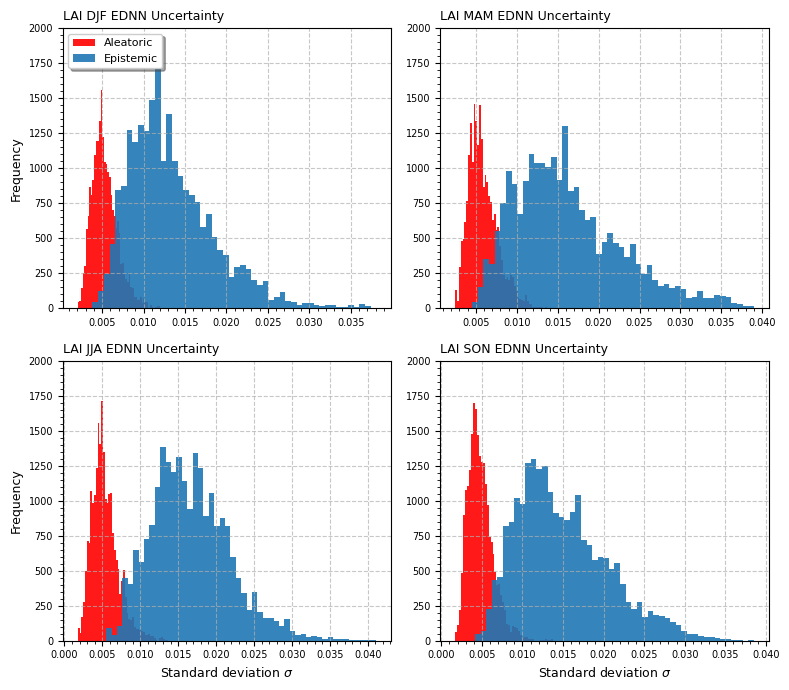

In [28]:
# =============================================================================
# Plotting Histograms for Seasonal EDNN Uncertainties
# =============================================================================

# ---------- Define seasonal data as a list of tuples (prediction_array, season_name)
season_data = [
    (djf_pred_, "DJF"),
    (mam_pred_, "MAM"),
    (jja_pred_, "JJA"),
    (son_pred_, "SON")
]

# ---------- Create a figure with a 2x2 grid of subplots
plt.figure(figsize=(8, 7))

# ---------- Set y-axis limits (optional)
y_limit = (0, 2000)

# ---------- Loop through each season and generate the histograms
for i, (data, season) in enumerate(season_data, 1):
    # ---------- Create a subplot in a 2x2 grid
    plt.subplot(2, 2, i)
    
    # ---------- Plot histogram of square-root of aleatoric uncertainty
    plt.hist(np.sqrt(data[:, 1]), bins=50, alpha=0.9, color="r", label='Aleatoric')
    # ---------- Plot histogram of square-root of epistemic uncertainty
    plt.hist(np.sqrt(data[:, 2]), bins=50, alpha=0.9, label='Epistemic')
    
    # ---------- Set x-axis label for subplots in the bottom row
    if i in [3, 4]:
        plt.xlabel('Standard deviation $\sigma$', fontsize=9)
    
    # ---------- Set y-axis label for subplots in the left column
    if i in [1, 3]:
        plt.ylabel('Frequency', fontsize=9)
    
    # ---------- Add legend only in the first subplot
    if i == 1:
        plt.legend(loc='upper left', fontsize=8, frameon=True, shadow=True, fancybox=True)
    
    # ---------- Set y-axis limits as specified
    plt.ylim(y_limit)
    
    # ---------- Set subplot title with season name
    plt.title(f'LAI {season} EDNN Uncertainty', fontsize=9, fontweight='regular', loc="left")
    
    # ---------- Customize tick fonts and enable minor ticks
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.tick_params(axis='both', which='major', labelsize=7)
    plt.minorticks_on()
    
    # ---------- Enable grid for the subplot
    plt.grid(True, linestyle='--', alpha=0.7)

# ---------- Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/_lai_hist.pdf", format='pdf', bbox_inches='tight')
plt.show()

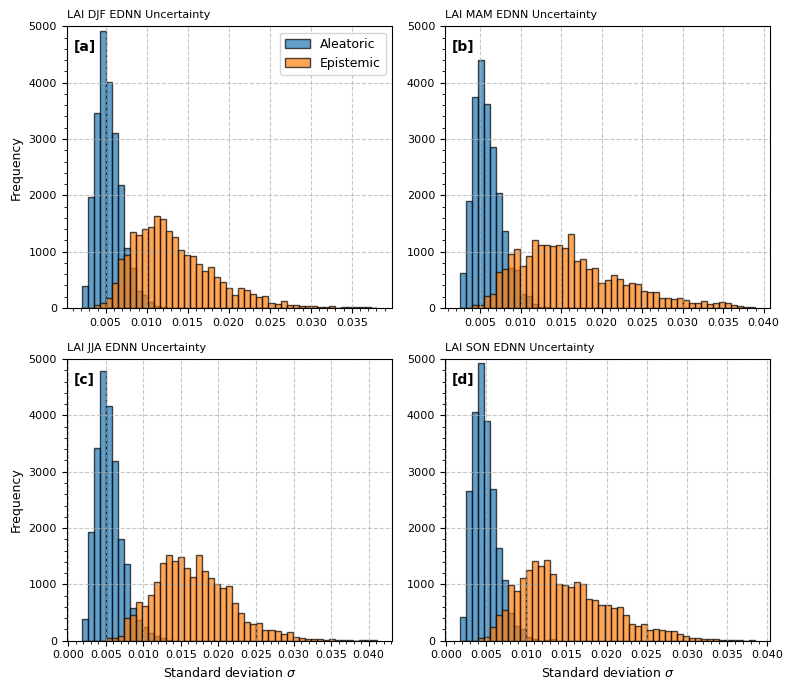

In [29]:
# =============================================================================
# 2x2 Histograms of Seasonal EDNN Uncertainties
# =============================================================================

# %% [code]
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm  # (if needed later; here not used directly)

# ---------- Set global PDF settings for publication-quality fonts
plt.rcParams['pdf.fonttype'] = 42  # Embed fonts in PDF
plt.rcParams['ps.fonttype'] = 42

# ---------- Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
y_limit = (0, 5000)
colors = {'aleatoric': 'C0', 'epistemic': 'C1'}

# ---------- Define subplot labels
subplot_labels = ['[a]', '[b]', '[c]', '[d]']

# ---------- Loop through subplots with corresponding season data and labels
for ax, (data, season), sub_label in zip(axs.ravel(), season_data, subplot_labels):
    # ---------- Compute the square-root transformation for uncertainties
    aleatoric = np.sqrt(data[:, 1])
    epistemic = np.sqrt(data[:, 2])
    
    # ---------- Determine a common binning for both histograms using combined data
    all_data = np.concatenate((aleatoric, epistemic))
    bins = np.linspace(all_data.min(), all_data.max(), 50)
    
    # ---------- Plot histograms with enhanced aesthetics: bar plots with edge colors
    ax.hist(aleatoric, bins=bins, alpha=0.7, color=colors['aleatoric'],
            edgecolor='black', label='Aleatoric')
    ax.hist(epistemic, bins=bins, alpha=0.7, color=colors['epistemic'],
            edgecolor='black', label='Epistemic')
    
    # ---------- Set axis limits and subplot title
    ax.set_ylim(y_limit)
    ax.set_title(f'LAI {season} EDNN Uncertainty', fontsize=8, loc="left")
    
    # ---------- Set x-axis label only on subplots in the bottom row
    if ax in [axs[1, 0], axs[1, 1]]:
        ax.set_xlabel('Standard deviation $\sigma$', fontsize=9)
    else:
        ax.set_xlabel('')
    
    # ---------- Set y-axis label only on subplots in the left column
    if ax in [axs[0, 0], axs[1, 0]]:
        ax.set_ylabel('Frequency', fontsize=9)
    else:
        ax.set_ylabel('')
    
    # ---------- Configure tick parameters and add minor ticks and gridlines
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.minorticks_on()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # ---------- Annotate the subplot with its label (e.g., [a])
    ax.text(0.02, 0.95, sub_label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    
    # ---------- Add legend to the first subplot only
    if ax == axs[0, 0]:
        ax.legend(loc='upper right', fontsize=9, frameon=True)

# ---------- Final layout adjustments and save the figure as PDF
plt.tight_layout()
plt.savefig("./Figures/_lai_hist.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()


## Sensitivity Analysis 

In [30]:
def fast_model(x_data, model, pred, M=1, num_resamples=100, conf_level=0.95):
    """
    Fourier Amplitude Sensitivity Test (FAST) analysis on the given model output.

    Parameters:
    - Data: The model output.
    - params: DataFrame containing parameters.
    - num_params: The number of parameters.
    - N: The number of samples to generate for the FAST analysis.
    - M: The interference parameter, the number of harmonics to sum in the Fourier series decomposition (default 1).
    - num_resamples: The number of resamples for bootstrap (default 100).
    - conf_level: The confidence level for the bootstrap (default 0.95).

    This function first reshapes the model output and then performs the FAST analysis using the SALib library.
    """

    #--------------- Define the problem for FAST analysis
    problem = {
        'names': x_data.columns,
        'num_vars': len(x_data.columns),
        'bounds': [[-1.732, 2.2] for x in range(35)],
    }
    #---------------- Load model
    # loaded_emulator = tf.saved_model.load('/glade/work/ksilwimba/PPE-Optimization/NN_Emulator/Saved_Model/model_'+str(num))
    #---------------- Perform the FAST analysis
    sample = fast_sampler.sample(problem, 100000, M=4, seed=None)
    Y = model.predict(sample)#,return_uncertainties=True)
    # y_mean = Y.numpy().mean(axis=1).flatten()
    
    TWS_FAST = fast_analyze.analyze(problem, Y[:,pred].flatten(), M=4, num_resamples=100,\
                            conf_level=0.95, print_to_console=True)
    #[mu, aleatoric, epistemic]
    return TWS_FAST 

#### Season FAST

In [31]:
#------------ DJF
lai_djf_fast = fast_model(x_dja_tr, model_djf,pred=0, M=4, num_resamples=100000, conf_level=0.95)
Si_djf = pd.DataFrame.from_dict(lai_djf_fast)
Si_djf.index = Si_djf.names
df_Si_djf = Si_djf.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 3s 966us/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.017104  0.031684  0.000163  0.004486
KCN                  0.002029  0.023941  0.000212  0.004514
a_fix                0.006506  0.020498  0.000191  0.004558
crit_dayl            0.000929  0.012601  0.000158  0.004146
d_max                0.000435  0.012321  0.000195  0.004338
fff                  0.003527  0.016817  0.000138  0.003912
froot_leaf           0.049034  0.067117  0.000138  0.003885
fstor2tran           0.000756  0.015759  0.000162  0.003655
grperc               0.006244  0.020386  0.000146  0.004155
jmaxb0               0.136383  0.156855  0.000138  0.004388
jmaxb1               0.051192  0.063135  0.000168  0.004771
kcha                 0.000446  0.012660  0.000148  0.004461
kmax                 0.083826  0.099695  0.000173  0.004071
krmax                0.000539  0.011583  0.000183  0.003893
leaf_long            0.109527  0.126243  0.000162  0.00

In [32]:
#------------ MAM
lai_mam_fast = fast_model(x_mam_tr, model_mam,pred=0, M=4, num_resamples=100000, conf_level=0.95)
Si_mam = pd.DataFrame.from_dict(lai_mam_fast)
Si_mam.index = Si_mam.names
df_Si_mam = Si_mam.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.015969  0.028706  0.000191  0.003601
KCN                  0.001481  0.015475  0.000162  0.004550
a_fix                0.009445  0.020902  0.000154  0.004204
crit_dayl            0.002508  0.013978  0.000161  0.004057
d_max                0.000656  0.013207  0.000166  0.004346
fff                  0.006024  0.022565  0.000164  0.004406
froot_leaf           0.034912  0.046031  0.000187  0.003992
fstor2tran           0.002896  0.016098  0.000145  0.003848
grperc               0.008157  0.019044  0.000176  0.004212
jmaxb0               0.149308  0.167333  0.000168  0.004143
jmaxb1               0.078366  0.092778  0.000162  0.003993
kcha                 0.000549  0.012691  0.000158  0.004017
kmax                 0.092993  0.111890  0.000155  0.004164
krmax                0.001772  0.012632  0.000141  0.003993
leaf_long            0.094514  0.108809  0.000164  0.0040

In [33]:
#------------ JJA
lai_jja_fast = fast_model(x_jja_tr, model_jja, pred=0, M=4, num_resamples=100000, conf_level=0.95)
Si_jja = pd.DataFrame.from_dict(lai_jja_fast)
Si_jja.index = Si_jja.names
df_Si_jja = Si_jja.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 3s 977us/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.028859  0.046166  0.000156  0.003905
KCN                  0.002728  0.013365  0.000118  0.003941
a_fix                0.001768  0.013929  0.000141  0.003822
crit_dayl            0.004624  0.020608  0.000152  0.004051
d_max                0.001642  0.015181  0.000154  0.003649
fff                  0.002863  0.014844  0.000142  0.004050
froot_leaf           0.037420  0.051288  0.000143  0.004113
fstor2tran           0.001201  0.010501  0.000162  0.003673
grperc               0.008197  0.019319  0.000153  0.004203
jmaxb0               0.139796  0.157856  0.000167  0.004168
jmaxb1               0.052340  0.067153  0.000177  0.003924
kcha                 0.000780  0.011647  0.000165  0.003869
kmax                 0.057344  0.069895  0.000146  0.004314
krmax                0.003169  0.012870  0.000147  0.003605
leaf_long            0.049786  0.062442  0.000161  0.00

In [34]:
#------------ SON
lai_son_fast = fast_model(x_son_tr, model_son, pred=0, M=4, num_resamples=100000, conf_level=0.95)
Si_son = pd.DataFrame.from_dict(lai_son_fast)
Si_son.index = Si_son.names
df_Si_son = Si_son.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.039779  0.055757  0.000143  0.003976
KCN                  0.007338  0.023341  0.000158  0.004289
a_fix                0.009211  0.023483  0.000148  0.003671
crit_dayl            0.000451  0.015431  0.000182  0.004427
d_max                0.000956  0.013611  0.000165  0.003665
fff                  0.001374  0.014397  0.000165  0.003689
froot_leaf           0.048437  0.063856  0.000139  0.003732
fstor2tran           0.000344  0.014317  0.000150  0.004163
grperc               0.015249  0.027868  0.000162  0.004476
jmaxb0               0.164439  0.184157  0.000152  0.004231
jmaxb1               0.064578  0.080925  0.000156  0.004300
kcha                 0.003972  0.016649  0.000149  0.003816
kmax                 0.080900  0.096277  0.000142  0.004369
krmax                0.001310  0.018273  0.000148  0.004253
leaf_long            0.074708  0.093993  0.000165  0.0044

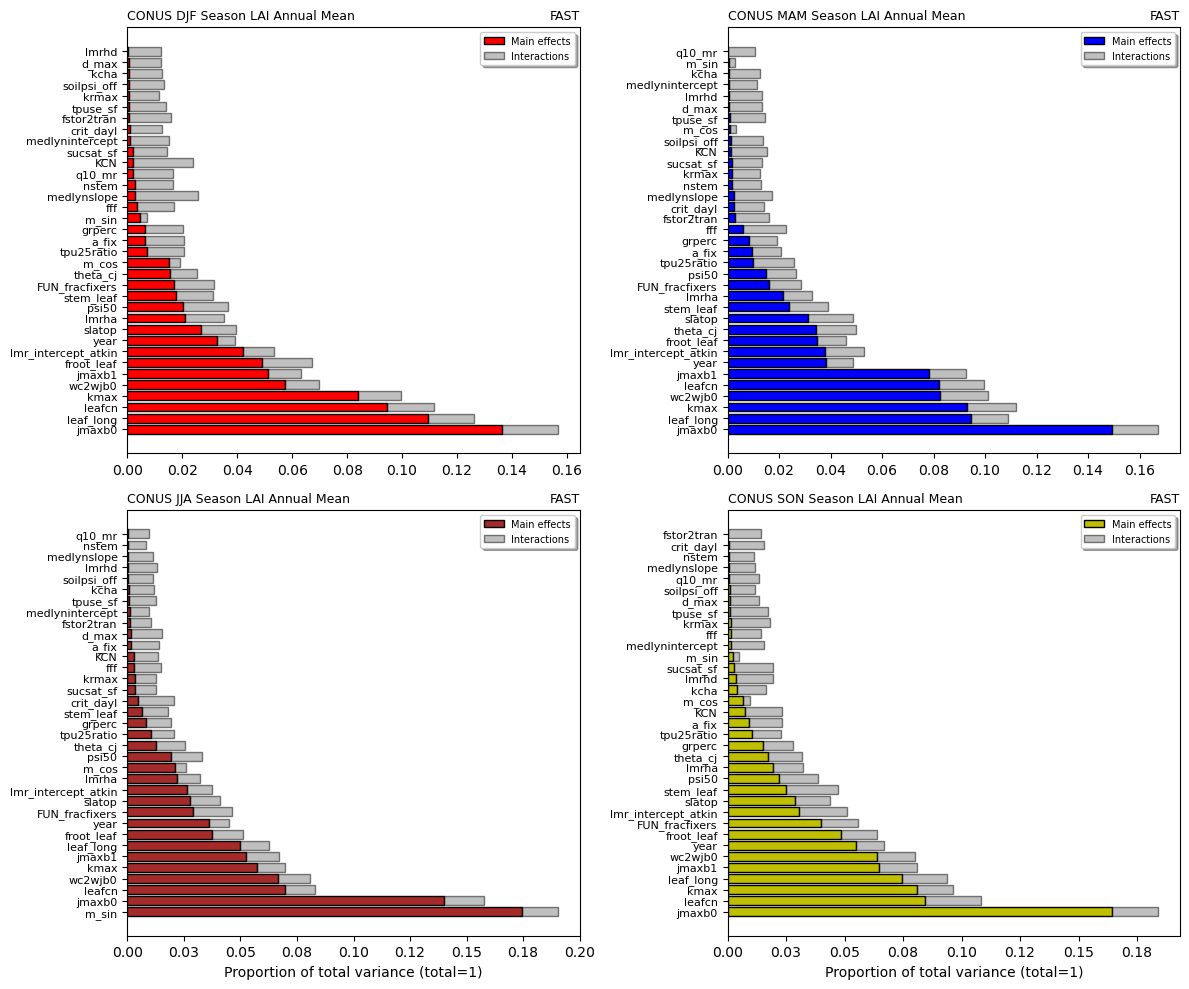

In [35]:
# =============================================================================
## FAST Sensitivity Plots for Seasonal LAI
# =============================================================================

# %% [code]
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# ---------- Define the helper function for plotting sensitivity
def plot_sensitivity(ax, df, title, bar_color, xlabel=False):
    """
    Plot horizontal bar charts showing FAST sensitivity main and interaction effects.
    
    Parameters:
        ax (matplotlib.axes.Axes): Axis object to plot on.
        df (pd.DataFrame): DataFrame containing sensitivity data with columns 'names', 'S1', and 'ST'.
        title (str): Title to display on the left of the subplot.
        bar_color (str): Color for the main effects bars.
        xlabel (bool, optional): If True, add an x-axis label. Default is False.
    """
    # ---------- Plot horizontal bar for main effects
    ax.barh(df.names, df['S1'], color=bar_color, label='Main effects', edgecolor='black')
    
    # ---------- Plot horizontal bar for interaction effects, stacked on the main effects
    ax.barh(df.names, df['ST'] - df['S1'], left=df['S1'], color='gray', label='Interactions', 
            alpha=0.5, edgecolor='black')
    
    # ---------- Customize tick labels and add legend
    ax.set_yticklabels(df.names, rotation=0, fontsize=8)
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=7)
    
    # ---------- Add x-axis label only if specified
    if xlabel:
        ax.set_xlabel('Proportion of total variance (total=1)')
    
    # ---------- Format x-axis ticks to 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # ---------- Set subplot titles: one on the left and "FAST" on the right
    ax.set_title(title, loc='left', fontsize=9)
    ax.set_title('FAST', loc='right', fontsize=9)

# ---------- Create a 2x2 grid of subplots for seasonal sensitivity plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=100)  # 2 rows, 2 columns

# ---------- Plot sensitivity for each season
plot_sensitivity(axes[0, 0], df_Si_djf, 'CONUS DJF Season LAI Annual Mean', 'r', xlabel=False)
plot_sensitivity(axes[0, 1], df_Si_mam, 'CONUS MAM Season LAI Annual Mean', 'b', xlabel=False)
plot_sensitivity(axes[1, 0], df_Si_jja, 'CONUS JJA Season LAI Annual Mean', 'brown', xlabel=True)
plot_sensitivity(axes[1, 1], df_Si_son, 'CONUS SON Season LAI Annual Mean ', 'y', xlabel=True)

# ---------- Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/FAST_Season.pdf", format='pdf', bbox_inches='tight')
plt.show()
